In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Concatenate, Input,Flatten
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import MaxNorm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
df = pd.read_csv("dispatch_data_updated.csv")

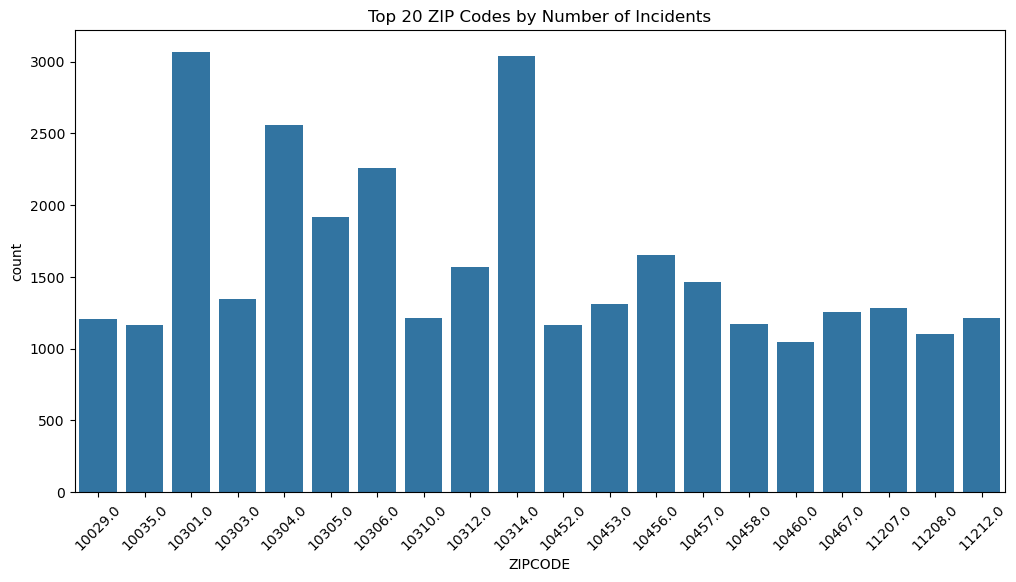

In [2]:
zipcode_counts = df.groupby('ZIPCODE').size().reset_index(name='count')

# Plot a bar chart for incidents by ZIPCODE
plt.figure(figsize=(12, 6))
sns.barplot(x='ZIPCODE', y='count', data=zipcode_counts.sort_values(by='count', ascending=False).head(20))
plt.title("Top 20 ZIP Codes by Number of Incidents")
plt.xticks(rotation=45)
plt.show()

In [3]:
zipcode_counts = df.groupby('ZIPCODE').size().reset_index(name='count')

# Sort by descending order of count and select the top 20
top_zipcodes = zipcode_counts.sort_values(by='count', ascending=False).head(20)
print(top_zipcodes)

    ZIPCODE  count
41  10301.0   3067
52  10314.0   3043
44  10304.0   2557
46  10306.0   2261
45  10305.0   1914
58  10456.0   1656
51  10312.0   1570
59  10457.0   1462
43  10303.0   1349
55  10453.0   1311
91  11207.0   1281
69  10467.0   1257
96  11212.0   1213
50  10310.0   1212
26  10029.0   1207
60  10458.0   1169
32  10035.0   1165
54  10452.0   1164
92  11208.0   1104
62  10460.0   1046


In [4]:
zipcode_to_coords = {
    '10301.0': (40.62473,-74.09454),
    '10314.0': (40.59615,-74.16161),
    '10304.0':(40.60721,-74.09530),
    '10306.0':(40.55987,-74.11501),
    '10305.0':(40.59731,-74.07706),
    '10456.0':(40.82933,-73.90813),
    '10312.0':(40.54170,-74.17893),
    '10457.0':(40.84641,-73.89845),
    '10303.0':(40.63256,-74.16824),
    '10453.0':(40.85361,-73.91358),
    '11207.0':(40.67130,-73.89521),
    '10467.0':(40.87665,-73.87151),
    '11212.0':(40.66437,-73.91533),
    '10310.0':(40.63316,-74.11618),
    '10029.0':(40.79171,-73.94332),
    '10458.0':(40.86494,-73.88488),
    '10035.0':(40.79527,-73.93011),
    '10452.0':(40.83731,-73.92243),
    '11208.0':(40.67484,-73.87191),
    '10460.0':(40.84382,-73.87934)
}

In [8]:
coords_df = pd.DataFrame.from_dict(zipcode_to_coords, orient='index', columns=['latitude', 'longitude']).reset_index()
coords_df.rename(columns={'index': 'ZIPCODE'}, inplace=True)
top_zipcodes['ZIPCODE'] = top_zipcodes['ZIPCODE'].astype(str)
coords_df['ZIPCODE'] = coords_df['ZIPCODE'].astype(str)
top_zipcodes_with_coords = pd.merge(top_zipcodes, coords_df, on='ZIPCODE', how='left')

import folium

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add markers for the top 20 ZIP codes
for _, row in top_zipcodes_with_coords.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['count']/150,  # Adjust size based on count
        color='blue',
        fill=True,
        fill_color='blue',
        popup=f"ZIP Code: {row['ZIPCODE']}<br>Count: {row['count']}"
    ).add_to(nyc_map)

# Display the map
nyc_map

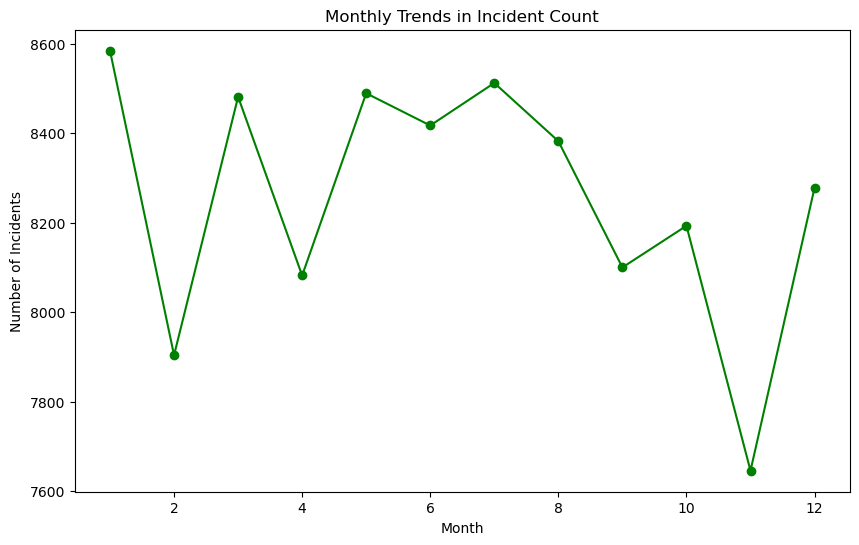

In [15]:
monthly_counts = df['month'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='line', marker='o', color='green')
plt.title("Monthly Trends in Incident Count")
plt.xlabel("Month")
plt.ylabel("Number of Incidents")
plt.show()

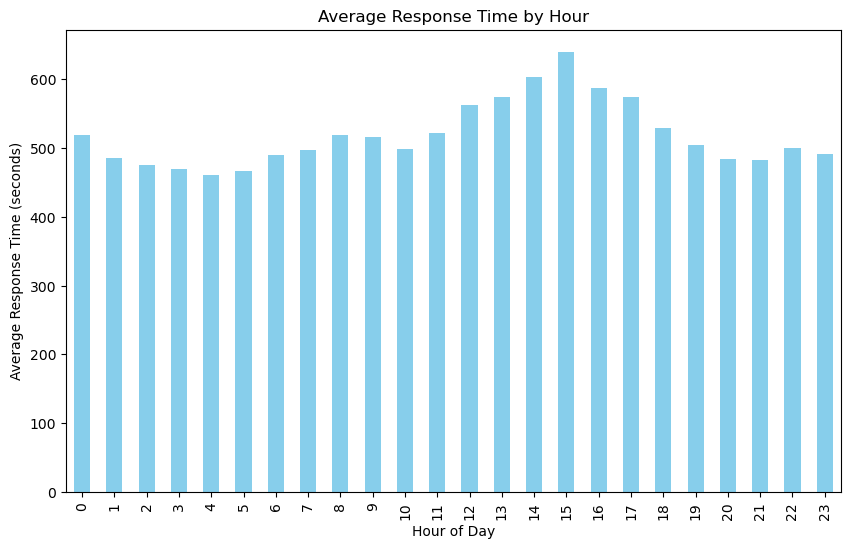

In [14]:
hourly_response = df.groupby('hour')['INCIDENT_RESPONSE_SECONDS_QY'].mean()

# Plot
plt.figure(figsize=(10, 6))
hourly_response.plot(kind='bar', color='skyblue')
plt.title("Average Response Time by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Response Time (seconds)")
plt.show()

In [16]:
df.head()

,ZIPCODE,INITIAL_CALL_TYPE,POLICEPRECINCT,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_DATETIME,Nearest_Traffic_Vol,Distance_m,PRECINCT_encoded,ZIPCODE_encoded,CALL_TYPE_encoded,hour,day,month,day_of_week,average_response_time
0,10306.0,CVAC,122.0,329.0,2016-11-17 13:23:36,11.0,606.071581,20,46,31,13,17,11,3,447.597523
1,11434.0,DIFFBR,113.0,510.0,2012-04-23 09:38:42,32.0,794.490706,15,168,34,9,23,4,0,539.729332
2,11205.0,SICK,88.0,230.0,2012-04-22 15:53:38,649.0,469.163242,73,89,91,15,22,4,6,462.810881
3,10314.0,ALTMEN,121.0,322.0,2020-12-22 10:45:37,133.0,531.893522,19,52,3,10,22,12,1,466.060138
4,11426.0,EDP,105.0,474.0,2008-05-09 09:21:50,55.0,782.008555,7,161,40,9,9,5,4,459.363636


Correlation Matrix:


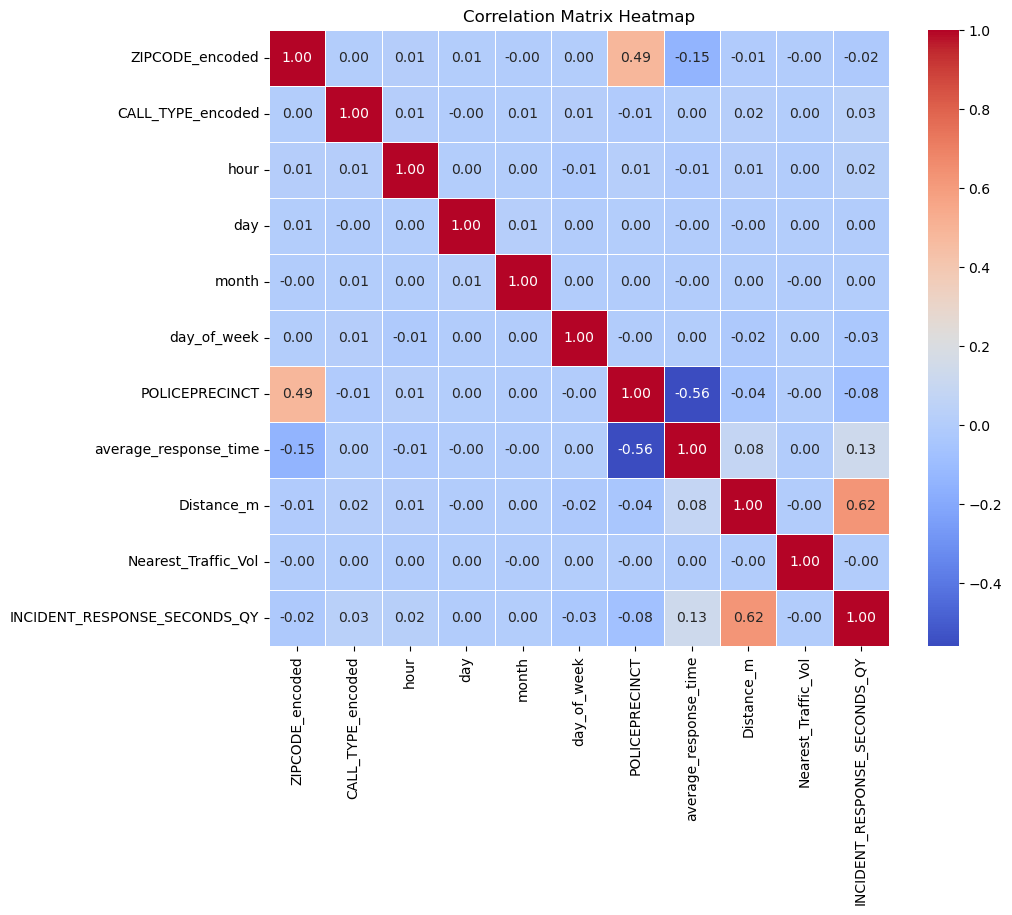

In [33]:
correlation_data = df[['ZIPCODE_encoded', 'CALL_TYPE_encoded', 'hour', 'day', 'month', 
        'day_of_week', 'POLICEPRECINCT', 'average_response_time','Distance_m','Nearest_Traffic_Vol','INCIDENT_RESPONSE_SECONDS_QY']]

correlation_matrix = correlation_data.corr()

print("Correlation Matrix:")

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [34]:
df.head()

,ZIPCODE,INITIAL_CALL_TYPE,POLICEPRECINCT,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_DATETIME,Nearest_Traffic_Vol,Distance_m,PRECINCT_encoded,ZIPCODE_encoded,CALL_TYPE_encoded,hour,day,month,day_of_week,average_response_time
0,10306.0,CVAC,122.0,329.0,2016-11-17 13:23:36,11.0,1233.412621,20,46,31,13,17,11,3,447.597523
1,11434.0,DIFFBR,113.0,510.0,2012-04-23 09:38:42,32.0,749.192192,15,168,34,9,23,4,0,539.729332
2,11205.0,SICK,88.0,230.0,2012-04-22 15:53:38,649.0,850.011017,73,89,91,15,22,4,6,462.810881
3,10314.0,ALTMEN,121.0,322.0,2020-12-22 10:45:37,133.0,956.788602,19,52,3,10,22,12,1,466.060138
4,11426.0,EDP,105.0,474.0,2008-05-09 09:21:50,55.0,466.091529,7,161,40,9,9,5,4,459.363636


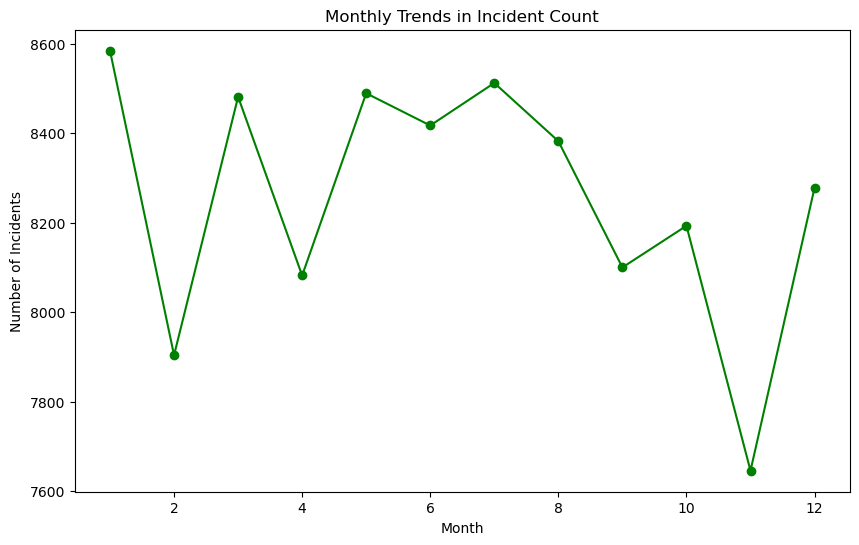

In [36]:
monthly_counts = df['month'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='line', marker='o', color='green')
plt.title("Monthly Trends in Incident Count")
plt.xlabel("Month")
plt.ylabel("Number of Incidents")
plt.show()